### Phase 5 — Model Explainability with Grad-CAM

#### Objective
Interpret and visualize the contribution of satellite imagery to the price prediction model using Grad-CAM. This notebook provides qualitative evidence that the CNN attends to semantically meaningful environmental features relevant to real estate valuation.

#### Key Steps
- Load the trained residual CNN
- Apply Grad-CAM to the final convolutional layers
- Generate heatmaps over satellite images
- Analyze visual patterns associated with high- and low-value properties

#### Output
- Grad-CAM visualizations highlighting influential image regions
- Saved explainability figures for inclusion in the final report


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_PATH = "..data/processed/train_clean.csv"
IMAGE_DIR = "..data/processed/images/train"
MODEL_PATH = "..models/residual_cnn.pt"
OUTPUT_DIR = "..outputs/gradcam"

os.makedirs(OUTPUT_DIR, exist_ok=True)
DEVICE

'cpu'

In [16]:
df = pd.read_csv(DATA_PATH)

def image_exists(pid):
    pid = str(int(pid))
    return os.path.exists(os.path.join(IMAGE_DIR, f"{pid}.0.png"))

df = df[df["id"].apply(image_exists)].reset_index(drop=True)
len(df)

16208

In [17]:
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [18]:
class ResidualImageModel(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.regressor = nn.Linear(512, 1)

    def forward(self, x):
        feat = self.backbone(x)
        out = self.regressor(feat)
        return out.squeeze()

In [19]:
backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
backbone.fc = nn.Identity()

model = ResidualImageModel(backbone).to(DEVICE)
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


ResidualImageModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [20]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(_, __, output):
            self.activations = output.detach()

        def backward_hook(_, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, x):
        self.model.zero_grad()
        output = self.model(x)
        output.backward(torch.ones_like(output))

        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy()[0]

In [21]:
target_layer = model.backbone.layer4[-1].conv2
gradcam = GradCAM(model, target_layer)

In [22]:
def overlay_cam(image_path, cam, output_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    cam_resized = cv2.resize(cam, (224, 224))

    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_resized),
        cv2.COLORMAP_JET
    )

    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite(output_path, overlay)

In [23]:
TOP_K = 5

high_value = df.nlargest(TOP_K, "log_price")
low_value = df.nsmallest(TOP_K, "log_price")

In [24]:
def run_gradcam(df_subset, prefix):
    for _, row in df_subset.iterrows():
        pid = int(row["id"])
        img_path = os.path.join(IMAGE_DIR, f"{pid}.0.png")

        image = Image.open(img_path).convert("RGB")
        input_tensor = image_transform(image).unsqueeze(0).to(DEVICE)

        cam = gradcam.generate(input_tensor)

        output_path = os.path.join(
            OUTPUT_DIR,
            f"{prefix}_{pid}.png"
        )

        overlay_cam(img_path, cam, output_path)

In [25]:
run_gradcam(high_value, "high_value")
run_gradcam(low_value, "low_value")

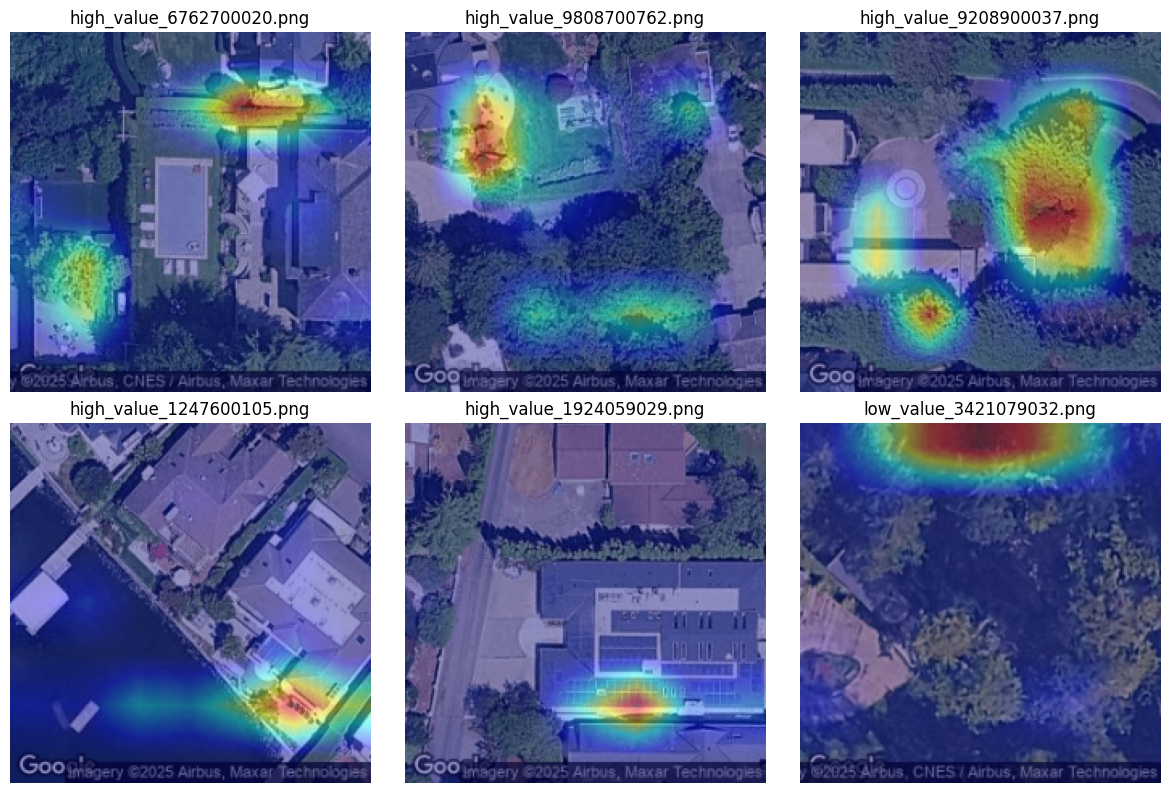

In [26]:
sample_imgs = os.listdir(OUTPUT_DIR)[:6]

plt.figure(figsize=(12,8))
for i, img_name in enumerate(sample_imgs):
    plt.subplot(2,3,i+1)
    img = Image.open(os.path.join(OUTPUT_DIR, img_name))
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")

plt.tight_layout()
plt.show()